In [1]:
!python -V

Python 3.6.8 :: Anaconda, Inc.


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import pickle
from geopy.distance import geodesic
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import requests
import json

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# YELP_DATA = if we'll create data from Yelp Api (True) or we'll load it from a file (False).
YELP_DATA = False


# 1 - Intro

I'll work with the famous Airbnb Seattle dataset, this dataset contains two files:
1. calendar.csv
2. listings.csv  

The purpose of this project is to predict the price of Seattle Airbnb rentals based on the data provided and also using external data from YELP API.



# 2 - Helper Functions

In [4]:
def change_to_boolean(df,cols):
    '''
    function that receives dataframe df and columns where to change 't' to 1 and 'f' to 0
    cols = list of columns
    '''
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: 1 if s=='t' else 0)

def change_from_dollar(df,cols):
    '''
    function that receives a dataframe df and columns where to change from price string format "$1,000.00" to float
    '''
    
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: s if s is np.nan else float(s.replace(',','')[1:]))
        
def change_from_percentage(df, cols):
    '''
    function that receives a dataframe df and columns where to change from string format '34%' to float 34
    '''
    for col in cols:
        df.loc[:,col] = df[col].apply(lambda s: s if s is np.nan else float(s.replace('%','')))
        
def transform_and_return(df,features,model):
    '''
    Function that receives a dataframe, its features and an already fitted transformer and applies the
    transformer and returns the output as a dataframe
    '''
    
    df =model.transform(df)
    df = pd.DataFrame(df,columns=features)
    df.reset_index(drop=True,inplace=True)
    return df

    
def agregate_categories(df1,df2,df3,cols):
    '''
    function that agregates categories in variables that have lots of categories
    
    '''

    for col in cols:

        value_c = df1[col].value_counts()
        vals = value_c.index[:5]
        df1[col] =df1[col].where(df1[col].isin(vals), 'other')
        df2[col] =df2[col].where(df2[col].isin(vals), 'other')
        df3[col] =df3[col].where(df3[col].isin(vals), 'other')

def dataframe_with_dummies(df,dummies,encoder,features):
    """
    function that receives df dataframe with the independent features and does OHE transformation with
    the already fitted encoder "encoder" and returns a dataframe with all of the OHE features, the rest of the features
    of the df dataframe 

    """
    df_dummies = pd.DataFrame(data = encoder.transform(df[dummies]).toarray(),columns = encoder.get_feature_names(dummies))                        
    df = pd.concat([df[features], df_dummies], axis=1)
    df.columns = features + list(encoder.get_feature_names(dummies))
    return df       

def plot_feature_importance(importance,names,model_type,num_features):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:num_features,:num_features]
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    return list(fi_df['feature_names'])

def get_best_features(importance,names,model_type,num_features):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:num_features,:num_features]
    

    return list(fi_df['feature_names'])
    
def distance_latlon(point1, point2):
    '''
    Function that receives the latitude and longitude of 2 points (point1 and point2 are tuples) and returns  
    the distance in kilometers
    '''
    
    return geodesic(point1, point2).km

def model_output(y_val,y_preds):
    
    R2 = r2_score(y_val,y_preds)
    MSE = mean_squared_error(y_val,y_preds)
    MAE = mean_absolute_error(y_val,y_preds)
    MAPE = mean_absolute_percentage_error(y_val,y_preds)
    print('R^2: ',R2)
    print('MSE: ',MSE)
    print('MAE: ',MAE)
    print('MAPE: ',MAPE)
    
    
# helper functions to retrive new data to add
def get_data_to_add(listing,avg_per_period,summer, weekend):
    '''
    Function that receives listing dataframe and with the information in the avg_per_period data frame, converts the  
    data in listing to that of the period of summer and weekend that could be 1 or 0 each.  
    Then returns the new data to add to the dataset
    '''
    
    features = list(listing.columns)
    my_listing = listing.copy()
    my_listing.drop(columns=['price'],inplace=True)
    my_listing.summer = summer
    my_listing.weekend = weekend

    add_listing = avg_per_period[(avg_per_period.summer==summer)&(avg_per_period.weekend==weekend)]
    add_listing.drop(columns=['summer','weekend','avg_price'],inplace=True)

    my_listing =  my_listing.merge(add_listing,left_on='id', right_on='listing_id', how='left')
    my_listing = my_listing[~my_listing.price.isna()]
    my_listing = my_listing[features]
    return my_listing

def get_data_all_period(listing, avg_per_period):
    '''
    Function that for one listing dataframe returns the listing, having added information from same listings in
    different periods
    '''
    my_listing= listing.copy()
    for pair in [[1,1],[1,0],[0,1]]:
        my_listing = pd.concat([my_listing,get_data_to_add(listing,avg_per_period,pair[0],pair[1])],ignore_index=True)
    
    return my_listing


In [5]:
# to impute later on
mostf_filler = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent'))
])

mean_filler = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean'))
])

# 3 - Loading the data

In [6]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

# added this option so i could scroll through all the columns with head() or sample() methods
pd.set_option('max_columns',None)

# 4 - Cleaning the data

## 4.1 - Listings DataFrame

In [7]:
#shape
listings.shape

(3818, 92)

In [8]:
# we'll look at the data to have a better understanding
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [9]:
#we'll check the info
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [10]:
#let's check the columns with nan values
listings.isna().sum()[listings.isna().sum() >0]

summary                         177
space                           569
neighborhood_overview          1032
notes                          1606
transit                         934
thumbnail_url                   320
medium_url                      320
xl_picture_url                  320
host_name                         2
host_since                        2
host_location                     8
host_about                      859
host_response_time              523
host_response_rate              523
host_acceptance_rate            773
host_is_superhost                 2
host_thumbnail_url                2
host_picture_url                  2
host_neighbourhood              300
host_listings_count               2
host_total_listings_count         2
host_has_profile_pic              2
host_identity_verified            2
neighbourhood                   416
zipcode                           7
property_type                     1
bathrooms                        16
bedrooms                    

We see that there are a lot of features with nan values.  


Before dealing with those we'll delete some features weather they have too many nan values or because the information  
is useless or in order to be used it's out of the scope of this project (for example use of NLP to get value from data).

### 4.1.1 - Deleting features
**Features i'll delete**  
- scrape_id,experiences_offered,city,market,smart_location,country_code,country,requires_license,license  
jurisdiction_names: beacuse all raws are the same or almost    

- weekly_price,monthly_price because im predicting price so i can't use those features because would be lekeage. I could get a % of the price that goes down with weekly or monthly price, but it also makes sense that if i dont have price, i also don't have weekly or monthly, so makes no sense to use it.  
(Later on i could create a model that uses price as a feature and predict weekly or monthly price)    

- i'll also delete security_deposit and cleaning_fee because they have to many nan values    

- I'll also delete features with long strings that i dont find as useful (maybe if i would use nlp, but that's not the case).  
  Features like :'name','transit','street','neighbourhood_cleansed','picture_url','neighborhood_overview',     'space','host_about','thumbnail_url','host_picture_url','description','medium_url','host_thumbnail_url','xl_picture_url',  'notes','summary','neighbourhood_group_cleansed', 'host_url','listing_url'  
  
- Also some features that i don't see so much use for them:  
'first_review','last_scraped','calendar_last_scraped','last_review','host_name'

- I'll also delete 'host_total_listings_count' because it's the same as 'host_listings_count

In [11]:
to_delete = ['name','transit','street','neighbourhood_cleansed','picture_url','neighborhood_overview', 'space','host_about',
             'thumbnail_url','host_picture_url','description','medium_url','host_thumbnail_url','xl_picture_url','notes',
             'summary','neighbourhood_group_cleansed','host_url','listing_url','first_review',
             'calendar_last_scraped','last_review','host_name','calendar_updated','state','host_id','host_location',
             'scrape_id','square_feet','weekly_price','monthly_price','license','experiences_offered','city','market',
             'smart_location','country_code','country','requires_license','jurisdiction_names', 'security_deposit',
             'cleaning_fee','has_availability','host_acceptance_rate','host_total_listings_count']
listings.drop(columns=to_delete,inplace=True)


In [12]:
listings.shape

(3818, 48)

In [13]:
#first i'll change features that have values 't' and 'f' to 1 and 0
to_boolean = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
             'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
change_to_boolean(listings,to_boolean)

In [14]:
# change features that have % to float
change_from_percentage(listings,['host_response_rate'])

In [15]:
#change features that have format $1000,00 to float
change_from_dollar(listings,['price','extra_people'])

### 4.1.2 - BATHROOMS AND BEDROOMS  
Some values in bathrooms and bedrooms makes no sense.

In [16]:
print('Bathrooms and bedrooms are 0')
display(listings[(listings.bathrooms ==0) & (listings.bedrooms==0)][['room_type','bathrooms','bedrooms','accommodates','price']])

print('Bathrooms are 0, bedrooms are not')
display(listings[(listings.bathrooms ==0) & (listings.bedrooms!=0)][['room_type','bathrooms','bedrooms','accommodates','price']])

print('Bedrooms are 0, bathrooms are not')
listings[(listings.bathrooms !=0) & (listings.bedrooms==0)][['room_type','bathrooms','bedrooms','accommodates','price']]

Bathrooms and bedrooms are 0


,room_type,bathrooms,bedrooms,accommodates,price
1924,Entire home/apt,0.0,0.0,4,265.0
2202,Entire home/apt,0.0,0.0,2,75.0


Bathrooms are 0, bedrooms are not


,room_type,bathrooms,bedrooms,accommodates,price
1069,Shared room,0.0,1.0,8,38.0
1446,Private room,0.0,1.0,2,65.0
2276,Private room,0.0,1.0,2,40.0
2409,Private room,0.0,1.0,1,50.0
2560,Private room,0.0,1.0,2,55.0
2562,Private room,0.0,1.0,2,55.0


Bedrooms are 0, bathrooms are not


,room_type,bathrooms,bedrooms,accommodates,price
3,Entire home/apt,1.0,0.0,3,100.0
39,Entire home/apt,1.0,0.0,2,80.0
45,Entire home/apt,1.0,0.0,2,100.0
47,Entire home/apt,1.0,0.0,2,110.0
50,Entire home/apt,1.0,0.0,2,99.0
...,...,...,...,...,...
3795,Entire home/apt,1.0,0.0,4,200.0
3797,Entire home/apt,1.0,0.0,2,70.0
3804,Entire home/apt,1.0,0.0,2,125.0
3807,Entire home/apt,1.0,0.0,2,109.0


#### **Summary**  

It makes sense that the rows there bathrooms and bedrooms are 0 really should be nan's. They accommodate people, have value,  
so we have to change those values to nan's.  
Also the rows that have bedrooms=0 and bathrooms not 0 doesn't make sense. These values should be nan's instead of 0.  
The case of rows with bedrooms not 0 but bathrooms 0 could make sense if the room_type is a private or shared room.   
Let's check this out.

In [17]:
# checking the room type of these rows
listings[(listings.bathrooms ==0) & (listings.bedrooms!=0)].room_type.unique()

array(['Shared room', 'Private room'], dtype=object)

So now that we concluded this small analysis we'll change the values.

In [18]:
#first we'll change the value of the bathrooms where also bedrooms is 0
my_index = listings[(listings.bathrooms==0)&(listings.bedrooms==0)].index
listings.loc[my_index,'bathrooms'] = listings[(listings.bathrooms==0)&(listings.bedrooms==0)].bathrooms.apply(lambda x: np.nan if x ==0 else x)

#now we'll change all of the values where bedrooms are 0
my_index = listings[(listings.bedrooms==0)].index
listings.loc[my_index,'bedrooms'] = listings[(listings.bedrooms==0)].bedrooms.apply(lambda x: np.nan if x ==0 else x)


In [19]:
listings[listings.bedrooms==0].shape

(0, 48)

### 4.1.3 - Dealining with nan's 


In [20]:
#there are features that makes sense to fill 'NA' or the like. These are features that
#i plan to use those afterwards for feature creation, i'll just impute an auxiliar value for now to be able
#to process the data 
to_fill_NA = ['host_neighbourhood','neighbourhood']

for col in to_fill_NA:
    listings[col].fillna('NA',inplace=True)


In [21]:
#there are 2 rows that they dont have info about the host so since there are so few instead of imputing something
#i'll just drop them
listings = listings[~listings.host_since.isna()]

#i'll also drop rows with nan zipcode since there are so little nan rows and i dont want to use later on some demographic data
#that could be mistaken 
listings = listings[~listings.zipcode.isna()]
#also eliminate mistaken zipcode value
listings = listings[~(listings.zipcode=='99\n98122')]

listings.reset_index(drop=True,inplace=True)


#### Train test split  
In order that there would be no data lekeage i'll split the data before imputing values

In [22]:
listings_train_val, listings_test = train_test_split(listings, test_size=.2,random_state=12)
listings_train, listings_val = train_test_split(listings_train_val, test_size=.2,random_state=12)


In [23]:
#features to fill the nans with mean 

fill_with_mean = ['host_response_rate','review_scores_rating','review_scores_accuracy',
                 'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                 'review_scores_location','review_scores_value','reviews_per_month']

#features to fill the nans with most frequent 
fill_with_most_frequent = ['host_response_time','bathrooms','bedrooms','beds','property_type']

In [24]:
the_rest = list(set(listings.columns) - set(fill_with_mean)- set(fill_with_most_frequent))
features = fill_with_most_frequent +fill_with_mean +the_rest

In [25]:
listings_train = listings_train[features]
listings_val = listings_val[features]
listings_test = listings_test[features]

In [26]:
transformers = ColumnTransformer([
            ('mostf', mostf_filler, fill_with_most_frequent),
            ('mean',mean_filler,fill_with_mean),
            ('the_rest','passthrough',the_rest)
    ])

model = transformers.fit(listings_train)
listings_train = transform_and_return(listings_train,features,model)
listings_val = transform_and_return(listings_val,features,model)
listings_test = transform_and_return(listings_test,features,model)

In [27]:
#check the nans
print(listings_train.isna().sum()[listings_train.isna().sum()>0])
print(listings_val.isna().sum()[listings_val.isna().sum()>0])
print(listings_test.isna().sum()[listings_test.isna().sum()>0])



Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


We see that we have no Nans.  
That's it for now. Now we'll check the Calendar DataFrame

Last step, converting some features to a numerica datatype if it's possible

In [28]:
for df in [listings_train,listings_val,listings_test]:
    for col in listings_train.columns:
        try:
            for df in [listings_train,listings_val,listings_test]:
                df.loc[:,col] = pd.to_numeric(df[col])
        except:
            pass
        

## 4.2 - **Calendar DataFrame**

In [29]:
print('shape',calendar.shape)
calendar.head()

shape (1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We see that calendar has the id of one listing, the date of the listing, a "boolean" that explains if it is available and in case it is gives the price.  

In [30]:
#we'll check the column types 
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [31]:
#changing values in 'available' from 't' and 'f' to 1,0
change_to_boolean(calendar,['available'])

# changing type of 'date' from object to datetime. (i'll need this later on to manipulate this feature)
calendar['date']= pd.to_datetime(calendar['date'])

#change format from price
change_from_dollar(calendar,['price'])

In [32]:
# assert to check if price is only nan when listing not available and only not nan when it is
assert calendar[calendar.price.isna()].available.unique() == [0]
assert calendar[~calendar.price.isna()].available.unique() == [1]

We see that the nans really mean that there is no price because it's not available.  
We'll fill the value of the average for each property. 
For that we'll group by id and get the average.  

In [33]:
avg_price_per_id = calendar.groupby(calendar.listing_id).mean()
avg_price_per_id.reset_index(level=0, inplace=True)
avg_price_per_id = avg_price_per_id[['listing_id','price']]
avg_price_per_id.columns = ['listing_id','avg_price']
display(avg_price_per_id)

,listing_id,avg_price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000
...,...,...
3813,10332096,40.000000
3814,10334184,120.000000
3815,10339144,NaN
3816,10339145,237.904110


We see that there are properties that are not available for the whole year, therefore there's no value in the average.  
We'll delete those rows since we can't use that data.

In [34]:
ids_to_delete = list(avg_price_per_id[avg_price_per_id.avg_price.isna()].listing_id)
calendar = calendar[~calendar.listing_id.isin(ids_to_delete)]
display(calendar.head())


,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


In [35]:
calendar.shape

(1358895, 4)

In [36]:
# add avg_price to calendar df
calendar = calendar.merge(avg_price_per_id, on='listing_id', how='left')


# change value of price feature if it's nan
calendar.loc[:,'price'] = calendar.apply(lambda row: row['price'] if not np.isnan(row['price']) else row['avg_price'] ,axis=1)
calendar.drop(columns=['avg_price'],inplace=True)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,85.0
3,241032,2016-01-07,0,85.0
4,241032,2016-01-08,0,85.0


In [37]:
# check nans
calendar.isna().sum()[calendar.isna().sum()>0]

Series([], dtype: int64)

We see that there are no nan values.

# 5 - Analysis

## 5.1 - **Price distribution and Price vs features**

### 5.1.1 - Price Distribution

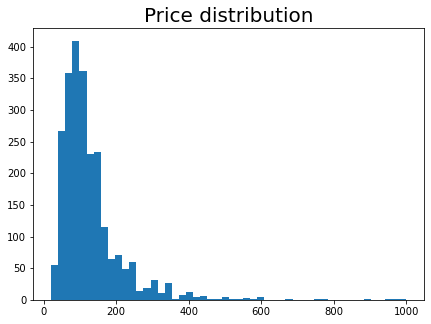

In [38]:
plt.figure(figsize=(7,5))
plt.hist(listings_train.price,bins=50)
plt.title('Price distribution',size=20)
plt.show()

We see that the price distribution is skewed to the left.   
There are also some points that seem to be outliers.  
Makes sense to deal with this outliers in the train set in order to train the model without this outliers because  
it could affect the model's performance.

In [39]:
# i'll eliminate the rows that are below and above 3 times the std of price (not so many rows).
#i'll only do this on the train set
mean_price = listings_train.price.mean()
std_price = listings_train.price.std()
min_price = mean_price-3*std_price
max_price = mean_price+3*std_price
line_d =listings_train.shape[0] -listings_train[(listings_train.price>=min_price)&(listings_train.price<=max_price)].shape[0]
print(f'{line_d} rows deleted')
listings_train =  listings_train[(listings_train.price>=min_price)&(listings_train.price<=max_price)]

41 rows deleted


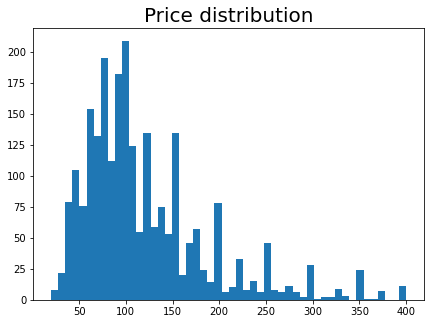

In [40]:
plt.figure(figsize=(7,5))
plt.hist(listings_train.price,bins=50)
plt.title('Price distribution',size=20)
plt.show()

### 5.1.2 - Price vs Features

#### Price vs Numerical Features  

In [41]:
# change the order of the features to see price at the end
rest = list(set(listings_train.columns) - set(['price']))
features = rest + ['price']
listings_train =  listings_train[features]
listings_val =  listings_val[features]
listings_test =  listings_test[features]


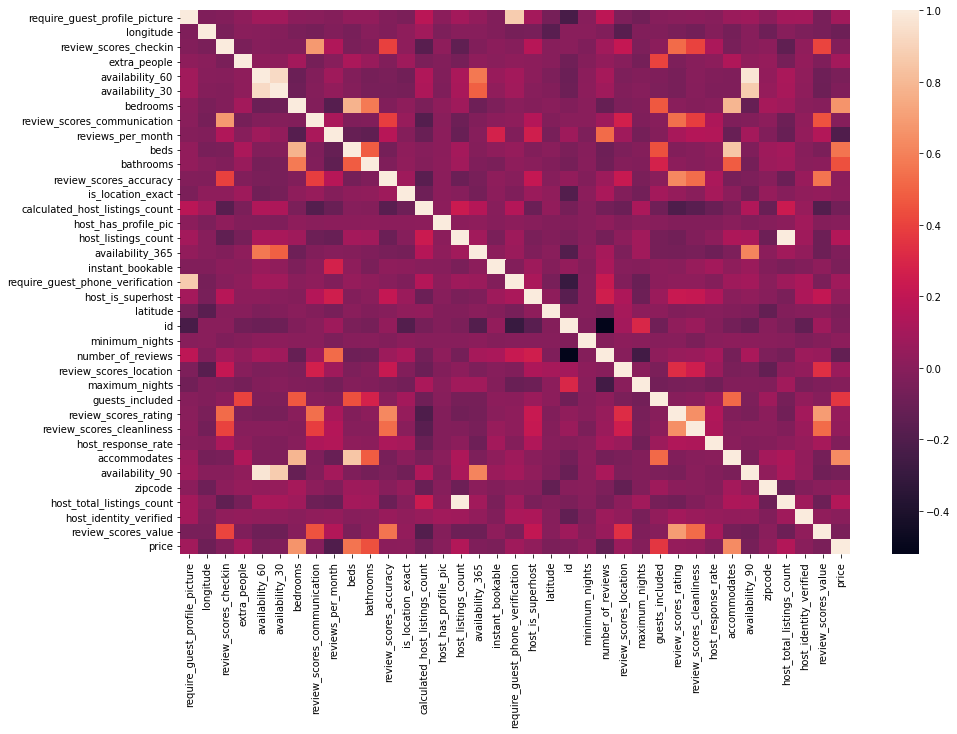

In [42]:
#let's look at a heatmap with the numerical variables
plt.figure(figsize = (15, 10))
sns.heatmap(listings_train.corr(), annot = False);

Even though there are a lot of features, we can see that there's a high correlation between [price] and  
[bedrooms, bathrooms, beds, accomodates] and also a "high" negative correlation with reviews_per_month (this  
could be due to the possibility that when there are lot's of reviews usually are bad reviews)

Looking at the data i found some features that we can clearly see that have a linear relation with the price.  
All of the "reviews_" stands to reason that might be highly correlated.  
It makes sense that the number of bedrooms, bathrooms, beds, guests included and accommodates are correlated to the price, since those  features clearly impact in the value of a property and/or use of it.    
We also find that the host_response_rate is very correlated and that makes sense since people are willing to pay more  
to have someone reliable as a host.


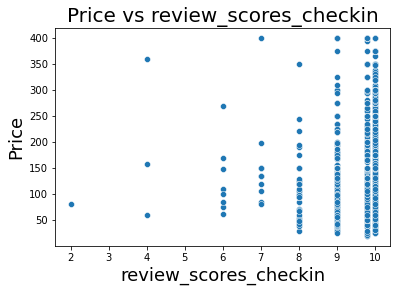

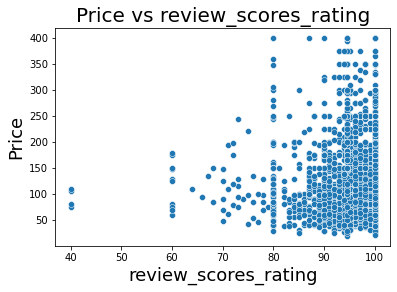

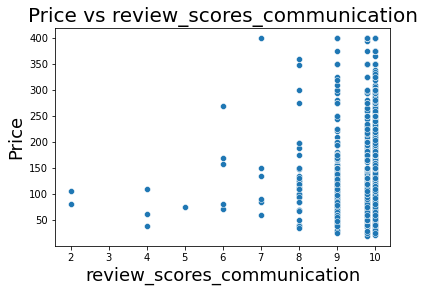

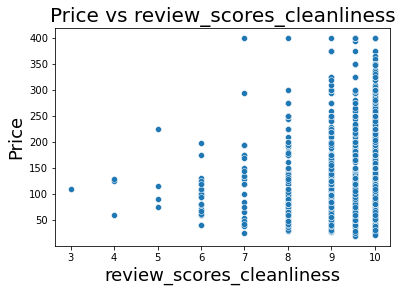

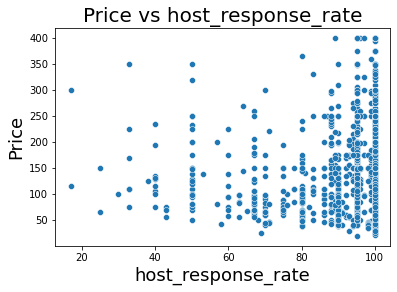

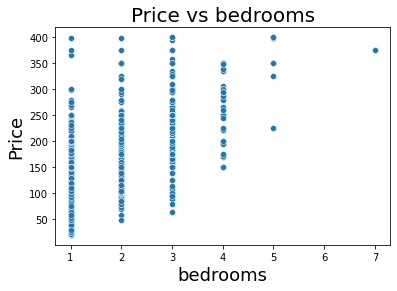

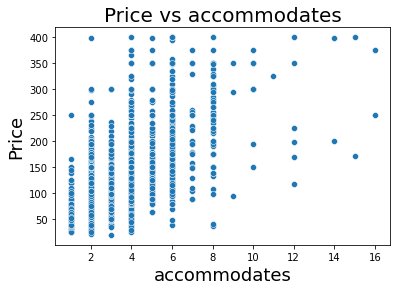

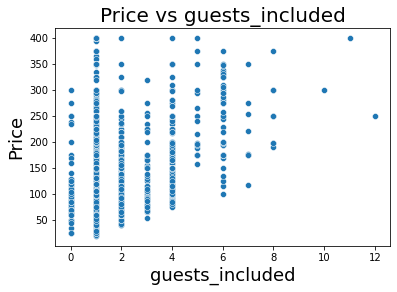

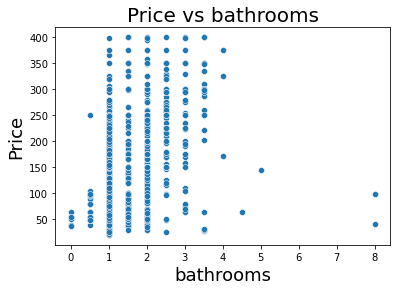

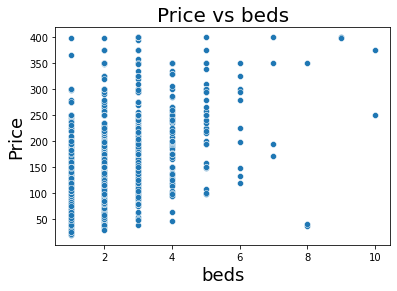

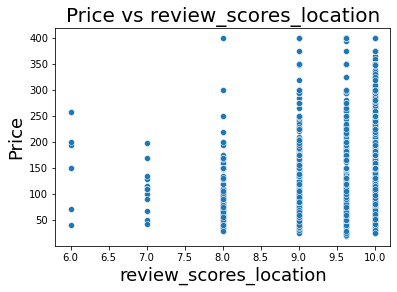

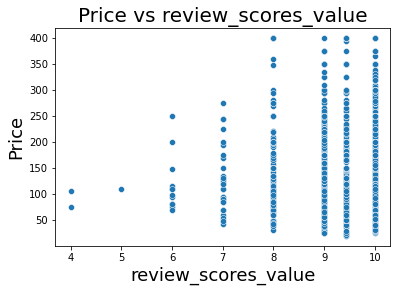

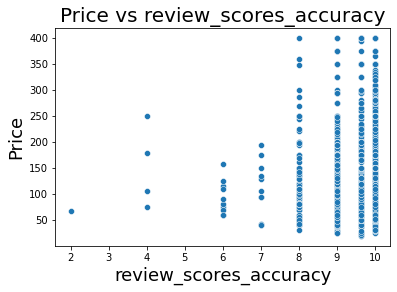

In [43]:
numerical_to_plot = ['review_scores_checkin', 'review_scores_rating', 'review_scores_communication',
 'review_scores_cleanliness', 'host_response_rate', 'bedrooms', 'accommodates', 'guests_included',
 'bathrooms', 'beds', 'review_scores_location', 'review_scores_value', 'review_scores_accuracy']


for col in numerical_to_plot:
    sns.scatterplot(data=listings_train, x=col, y="price")
    plt.title(f'Price vs {col}', size=20)
    plt.xlabel(f'{col}',size=18)
    plt.ylabel('Price',size=18)
    plt.show()

**Reviews vs price**  
I found something interesting in the number of reviews vs price.  
Let's see the plot:

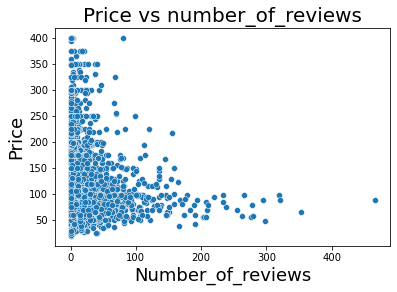

In [44]:
sns.scatterplot(data=listings_train, x='number_of_reviews', y="price")
plt.title(f'Price vs number_of_reviews', size=20)
plt.xlabel('Number_of_reviews',size=18)
plt.ylabel('Price',size=18)
plt.show()

We see something interesting.  
It seems that there is a slight increase in price as the number of reviews increase. But we also see that  
with very low number of reviews, there's really high prices.  
This could be explained by the fact that really expensive properties have less people renting it (maybe the same people tend  
to rotate renting the property) and therefore there are fewer reviews.  
But it could also be that good properties dont have so many complains so we only find high prices in properties with  
not so many reviews.  
Anyway, we see that a model could learn that if the number of reviews passes some threshold value, the price is   
likely to be lower.

**Latitude and Longitude**  
Latitude and longitude on it's own is not so simple to use since the actual number doesnt mean anything (unless we are  
using tree based models which could also work since it divides the data into subtrees until it gets to leafs).  
What we want to see is if the model could learn from these features but with these features in an independent way it's  
not likely to be useful since in one latitude point you could have many longitude points and that could cause a huge  
price variation.  
It's interesting to see if there's an specific area in the city, a polygone let's say, that has higher or lower value.

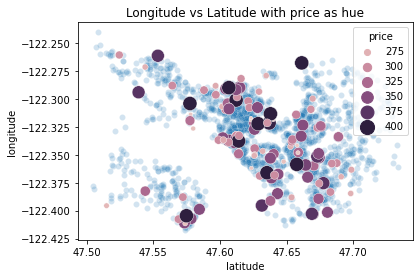

In [45]:
sns.scatterplot(data=listings_train[listings_train.price<=250], x="latitude", y="longitude", alpha=0.2)
sns.scatterplot(data=listings_train[listings_train.price>250], x="latitude", y="longitude", hue="price",sizes=(10, 200), size='price',alpha=1)

plt.legend(loc='upper right',title='price')
plt.title('Longitude vs Latitude with price as hue')
plt.show()



Clearly there seems to be like a "downtown" where the properties with higher price tend to be.  
In order to determine this specificly we could use something more sophisticated (like a clustering algorithm)  
but for the sake of this we'll simplify this using the plot so later on we'll create a new feature  
**is_downtown** that is 1 if it's in the area and 0 if not.  
Let's define the limits:  
  - latitude: 47.60 to 47.67  
  - longitude: -122.4 to -122.275  
  
Checking the Yelp Api (see 7.7), the center of seattle has coordenates :'longitude': -122.3355, 'latitude': 47.6254.  
I'll use that later one to create new feature called **distance_to_center**. It's true that from the center (being the center a place that's more expensive) you could move in 2 opposite ways and one is an expensive neighbourhood and the other direction is 
a cheap one, but still the distance to downtown life could add value to the property inspite it's intrinsic qualities.

#### Price vs Categorical

Here we can see some of the categorical variables that have a clear difference in their categories with respect price.

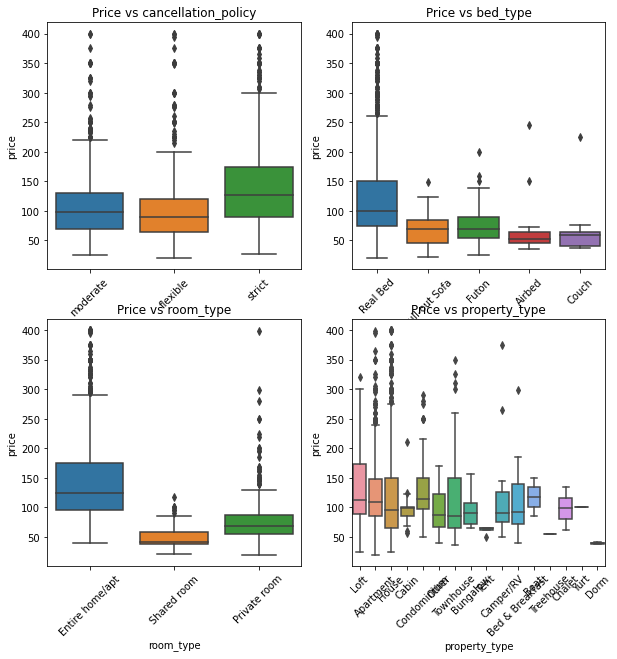

In [46]:
features_to_plot = ['cancellation_policy','bed_type','room_type','property_type']

fig, axs = plt.subplots(2, 2,figsize=(10,10))

counter = 0
for i in range(2):
    for j in range(2):
        sns.boxplot(ax =axs[i,j] ,x=features_to_plot[counter], y="price", data=listings_train)
        axs[i,j].set_title(f'Price vs {features_to_plot[counter]}')
        plt.sca(axs[i, j])

        plt.xticks(rotation=45)
        counter+=1

        
    
plt.show()


We see that the distribution of price in properties with a stricter cancellation policy has higher values  than the rest.  
We also see some things that were predictable, like the fact that an entire home/apt is more expensive than a room or that if  
the bed is a real bed it's more expensive than a Futon. We also have that a Loft is more expensive than other  
property types (we need to diminish the quantity of categories in this feature, but we'll deal with that later on).

## 5.2 - Feature distribution

### 5.2.1 - Numerical

Didn't find something peculiar besides what we already mentioned before.

### 5.2.2 - Categorical  
Some small things to comment:

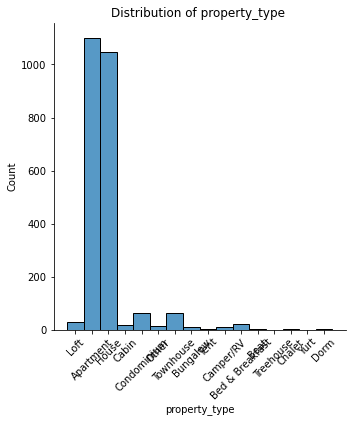

In [47]:
#property type

sns.displot(data = listings_train, x="property_type")
plt.xticks(rotation=45)
plt.title('Distribution of property_type ')
plt.show()

We see that besides 'apartment' and 'house', all of the other rest of properties are not so frequent. Even though some of  
these categories had different price distributions as we saw above, it makes sense to diminish the ammount of categories.  
We'll deal with this later on.

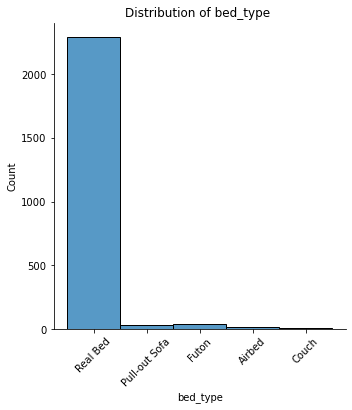

In [48]:
sns.displot(data = listings_train, x="bed_type")
plt.xticks(rotation=45)
plt.title('Distribution of bed_type ')

plt.show()

Almost all the values are Real Bed. It makes sense to change this feature to 1 if it is Real Bed or 0 if not.

## 5.3 Price information in Calendar dataframe

In the listings dataset we have only the price for 1 date, but in the calendar dataset we have more dates with their respective prices.  

### 5.3.1 - **Percentage of occupancy**  
It would be interesting to see if there's a clear relationship between the price of a property and the % of days it was booked  in 1 year as seen in the calendar df.

In [49]:

right_df =calendar.available.groupby(calendar['listing_id']).apply(lambda x: x.sum()/x.count()).reset_index(level=0)
right_df.columns=['id','occupancy']
right_df.head()

listings_train = listings_train.merge(right_df, on='id', how='left')
listings_val = listings_val.merge(right_df, on='id', how='left')
listings_test = listings_test.merge(right_df, on='id', how='left')
features = features +['occupancy']

In [50]:
# Fill Na in new feature with mean
for df in [listings_train,listings_val,listings_test]:
    df.fillna(listings_train.occupancy.mean(),inplace=True)


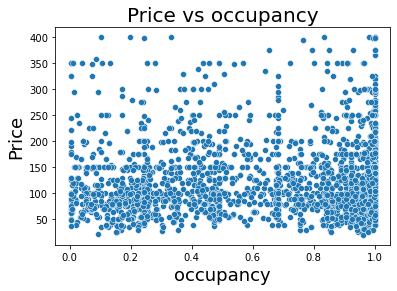

In [51]:
sns.scatterplot(data=listings_train, x='occupancy', y="price")
plt.title(f'Price vs occupancy', size=20)
plt.xlabel('occupancy',size=18)
plt.ylabel('Price',size=18)
plt.show()

I don't see a linear relationship, but i'll keep this feature because there could be a non linear impact on the price.

### 5.3.2 -  Price change though the year

It would be interesting to see if in average there is seasonality in weekends and in some period during the year.

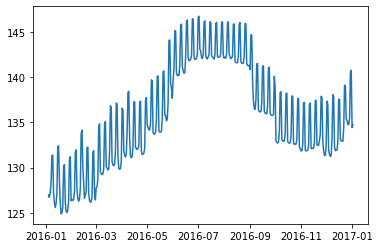

In [52]:
avg_price_per_date = pd.DataFrame(calendar.groupby(calendar.date).price.mean().values,index=calendar.groupby(calendar.date).price.mean().index, columns = ['avg_price_per_date'])
plt.plot(avg_price_per_date)

plt.show()

It seems clear that in average there's an increase during summer and maybe during new years.  
It's also seems to be clear that in every week there's an increse and then it goes down. This must be the weekend effect.  
There could also be a small trend.  
In order to improve our model we could add to the model the date of the listing and then add new features like  
- weekend or not
- summer or not  
  
and with this information we could add rows (same rows that we have but with a price modified by the listing price avg during summer or the % it increases during weekends. This would be different by each property since according to the particular   
attributes of each property the effect of these times would be different).

# 6 - Data Creation

As we said at the end of the previous section, we have valuable information in order to turn our model into a more complex  
model with the ability to distinguish between periods of time. In order to do this we have to create some data.  

Is **important** to mention that doing this could introduce bias (specially because there are some properties that later on  
we wont be able to get new information because their price data is not available in calendar dataframe and that is because it's rented through the whole year and those properties might have a specific reason why that happened), but in general the prices of properties , as we saw above, **DO** change in different periods and not be able to predict according to date would be a greater  loss for our model.   
That's way i decided to do this inspite of the possibility to add bias.

In [53]:
#calendar dataframe
#we'll add some features to the calendar dataframe
calendar['day_of_week'] = pd.DatetimeIndex(calendar.date).dayofweek
calendar['month'] = pd.DatetimeIndex(calendar.date).month
calendar['week'] = pd.DatetimeIndex(calendar.date).week
calendar['weekend'] = calendar['day_of_week'].apply(lambda x: 1 if x>=5 else 0) 

C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


With this new features we can now plot the average price per week.   
Let's see that.

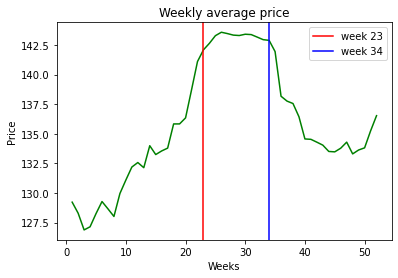

In [54]:
avg_price_per_week = pd.DataFrame(calendar.groupby(calendar.week).price.mean().values,index=calendar.groupby(calendar.week).price.mean().index, columns = ['avg_price_per_week'])
plt.plot(avg_price_per_week,c='g')
wi = 23
wf = 34
plt.title('Weekly average price')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.axvline(x=wi,color='r',label=f'week {wi}')
plt.axvline(x=wf,color='b',label=f'week {wf}')
plt.legend()

plt.show()

We see with this that around week 23 until week 34 the price is at it's peak. For sure it's not precise since there's   
a slope, but we can consider this period of time as something of an estimate of the summer rentals.  
It really is around 2 weeks before the beggining of summer and 2 weeks before the end of it. That could make sense since people  could get there early and leave a little before the end of summer to their homes to prepare for the new "year" (or school, etc).  
We'll create a feature that says if it is within that timeframe.

In [55]:
calendar['summer'] = calendar['week'].apply(lambda x: 1 if ((x>=23) & (x<=34)) else 0) 

In [56]:
calendar.head()

,listing_id,date,available,price,day_of_week,month,week,weekend,summer
0,241032,2016-01-04,1,85.0,0,1,1,0,0
1,241032,2016-01-05,1,85.0,1,1,1,0,0
2,241032,2016-01-06,0,85.0,2,1,1,0,0
3,241032,2016-01-07,0,85.0,3,1,1,0,0
4,241032,2016-01-08,0,85.0,4,1,1,0,0


We see that in the listings dataframes the value for last_scraped is the same for all, so that means that  
the price that we are getting is for that specific date.

In [57]:
listings_train.last_scraped.unique()


array(['2016-01-04'], dtype=object)

In [58]:
#we'll create features of 'summer', 'weekend'
for df in [listings_train,listings_val, listings_test]:
    df['weekend'] = 0
    df['summer'] = 0

I want to add new data in order to enable my model to diffirenciate by periods of time, weather it's summer or not, weather it's weekend or not.  
In order to do that i want for each listing in calendar dataframe to get the avg price in summer and not summer, and also if  
it's weekend or not.  
Since we inputed values when the listing wasnt available, there would be data that's not real, meaning that the data we have  
is that it is all the time the same price.  
Therefore i have to filter that data and only add data that did have values in each period of time.

In [59]:
#create dataframe with the price to create new data
df_avg_per_id_period = pd.DataFrame(calendar.groupby(['listing_id','summer','weekend']).price.mean()).reset_index(level=[0,1,2])


#create dataframe to have the average price in all the combinations (summer=[0,1], weekend =[0,1]) to check if the data is real
# meaning that it's highly unlikely that the price would be the same in every mommnent so a fast way to filter  
#data that we imputed because it was unavailable it is by filtering listings that have same price than the average
check_real_data = df_avg_per_id_period.groupby(df_avg_per_id_period.listing_id).price.mean().reset_index(level=0)
check_real_data.columns = ['listing_id','avg_price']

# merge the data to have a new column in order to see the rows that represent real data and filtering that
df_avg_per_id_period = df_avg_per_id_period.merge(check_real_data,on='listing_id',how='left')
df_avg_per_id_period = df_avg_per_id_period[df_avg_per_id_period.price!=df_avg_per_id_period.avg_price]


In [61]:
listings_train = get_data_all_period(listings_train,df_avg_per_id_period)
listings_val = get_data_all_period(listings_val,df_avg_per_id_period)
listings_test = get_data_all_period(listings_test,df_avg_per_id_period)

C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Dani

# 

# 7 - Feature Eng.


## 7.1 - Number of confirmations

It could be that the more ways of confirmation a host has, the higher trust people have, and therefore they could be willing to pay more for that.  
I'll create a feature called **num_conf** that is the number of different ways of confirmation.   
Later on  i'll drop the feature host_verifications

In [62]:
listings_train.shape,listings_val.shape, listings_test.shape

((6291, 51), (1678, 51), (2052, 51))

In [63]:
listings_train.head(2)

,require_guest_profile_picture,longitude,review_scores_checkin,extra_people,room_type,availability_60,availability_30,bedrooms,review_scores_communication,reviews_per_month,beds,amenities,host_verifications,bathrooms,review_scores_accuracy,is_location_exact,calculated_host_listings_count,host_has_profile_pic,last_scraped,host_listings_count,cancellation_policy,availability_365,instant_bookable,require_guest_phone_verification,host_is_superhost,latitude,neighbourhood,id,minimum_nights,number_of_reviews,review_scores_location,property_type,maximum_nights,host_neighbourhood,guests_included,review_scores_rating,review_scores_cleanliness,host_response_rate,host_since,accommodates,availability_90,bed_type,zipcode,host_response_time,host_total_listings_count,host_identity_verified,review_scores_value,price,occupancy,weekend,summer
0,0,-122.377170,10.0,0.0,Entire home/apt,55,28,1.0,10.0,3.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","['email', 'phone', 'facebook', 'google', 'link...",1.0,10.0,1,1,1,2016-01-04,1.0,moderate,351,1,0,0,47.632885,Interbay,6438013,1,3,9.0,Loft,1125,Interbay,1,93.0,10.0,100.0,2014-01-23,2,85,Real Bed,98119,within an hour,1.0,1,10.0,69.0,0.961644,0,0
1,0,-122.316204,10.0,20.0,Shared room,60,30,1.0,10.0,1.0,3.0,"{Internet,""Wireless Internet"",Kitchen,Heating,...","['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,10.0,1,2,1,2016-01-04,3.0,flexible,365,0,0,0,47.620333,Capitol Hill,9970805,1,1,10.0,Apartment,1125,Capitol Hill,1,100.0,10.0,80.0,2011-07-11,6,90,Real Bed,98102,within a day,3.0,1,10.0,39.0,1.000000,0,0


In [64]:
listings_train.loc[:,'num_conf'] = listings_train.host_verifications.apply(lambda s: s.count(',')+1)
listings_val.loc[:,'num_conf'] = listings_val.host_verifications.apply(lambda s: s.count(',')+1)
listings_test.loc[:,'num_conf'] = listings_test.host_verifications.apply(lambda s: s.count(',')+1)


## 7.2 - Years of host being active

How long a host has been host could also increase the trust, and as explained before, could have inpact in price.  

I'll create feature **'years_host'** that will represent the amount of years the host has been active.  
Ii'll use the date of last scraped as the date to compare.

In [65]:
#since i'm adding new data, summer or not, weekend or not, then i cant have NOW as it is in the commented code.
#i'll leave it in case i eliminate the added data
NOW =2016
listings_train.loc[:,'years_host'] = listings_train.host_since.apply(lambda x:(NOW - int(x[:4])))
listings_val.loc[:,'years_host'] = listings_val.host_since.apply(lambda x:(NOW - int(x[:4])))
listings_test.loc[:,'years_host'] = listings_test.host_since.apply(lambda x:(NOW - int(x[:4])))

## 7.3 - Same Neighbourhood

I want to use the features 'host_neighbourhood','neighbourhood' to create a new feature that is 1 if they are in the same  
neighbourhood or not. This makes sense since that adds more value because the host is more available to do things.

In [67]:
listings_train['same_neighbourhood'] =(listings_train.host_neighbourhood ==listings_train.neighbourhood)
listings_train.loc[:,'same_neighbourhood'] = listings_train.same_neighbourhood.apply(lambda x: 1 if x==True else 0)
listings_val['same_neighbourhood'] =(listings_val.host_neighbourhood ==listings_val.neighbourhood)
listings_val.loc[:,'same_neighbourhood'] = listings_val.same_neighbourhood.apply(lambda x: 1 if x==True else 0)
listings_test['same_neighbourhood'] =(listings_test.host_neighbourhood ==listings_test.neighbourhood)
listings_test.loc[:,'same_neighbourhood'] = listings_test.same_neighbourhood.apply(lambda x: 1 if x==True else 0)

## 7.4 - Binary features from Amenities

**Amenities**  
This feature could include many useful information. For sure with this we could create more features.  
First, let us explore a bit

In [68]:
listings_train.amenities[0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning","Wheelchair Accessible",Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly","Suitable for Events",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Fire Extinguisher",Essentials,Shampoo,"24-Hour Check-in",Hangers,"Laptop Friendly Workspace"}'

In [69]:
listings_train.amenities[2]

'{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises","Pets live on this property",Dog(s),Cat(s),Heating}'

Just looking at 2 different values we could see that there are many details that in order to search in a proper way it   
could get a little more complicated. For example in the first example we have TV,"Cable TV", meaning that in the item tv the   
type of tv is cable. But in the second example we only have TV within the cable tv.  
In order to make it more simple, for example, we could create if it has tv or not instead of doing a more complicated search looking for the exact type of tv it has.  The same with internet.    
  
 Let's see all of the different amenities in our train set

In [70]:
my_set = set()
for index in range(listings_train.shape[0]):
    s = listings_train.amenities[index]
    s = s.replace('"','').replace('{','').replace('}','')
    my_set = my_set.union(set(s.split(',')))

my_set    

{'',
 '24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family/Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Gym',
 'Hair Dryer',
 'Hangers',
 'Heating',
 'Hot Tub',
 'Indoor Fireplace',
 'Internet',
 'Iron',
 'Kitchen',
 'Laptop Friendly Workspace',
 'Lock on Bedroom Door',
 'Other pet(s)',
 'Pets Allowed',
 'Pets live on this property',
 'Pool',
 'Safety Card',
 'Shampoo',
 'Smoke Detector',
 'Smoking Allowed',
 'Suitable for Events',
 'TV',
 'Washer',
 'Wheelchair Accessible',
 'Wireless Internet'}

We'll create many binary features

In [71]:
for df in [listings_train,listings_val, listings_test]:
    df.loc[:,'has_ac'] = df.amenities.apply(lambda s: 1 if 'conditioning' in s.lower() else 0)
    df.loc[:,'has_internet'] = df.amenities.apply(lambda s: 1 if 'internet' in s.lower() else 0)
    df.loc[:,'has_pool'] = df.amenities.apply(lambda s: 1 if 'pool' in s.lower() else 0)
    df.loc[:,'has_tv'] = df.amenities.apply(lambda s: 1 if 'tv' in s.lower() else 0)
    df.loc[:,'smoking_allowed'] = df.amenities.apply(lambda s: 1 if 'smoking' in s.lower() else 0)
    df.loc[:,'washer'] = df.amenities.apply(lambda s: 1 if 'washer' in s.lower() else 0)
    df.loc[:,'smoke_detector'] = df.amenities.apply(lambda s: 1 if 'detector' in s.lower() else 0)
    df.loc[:,'pet_allowed'] = df.amenities.apply(lambda s: 1 if 'pet' in s.lower() else 0)
    df.loc[:,'kitchen'] = df.amenities.apply(lambda s: 1 if 'kitchen' in s.lower() else 0)
    df.loc[:,'iron'] = df.amenities.apply(lambda s: 1 if 'iron' in s.lower() else 0)
    df.loc[:,'fireplace'] = df.amenities.apply(lambda s: 1 if 'fireplace' in s.lower() else 0)
    df.loc[:,'hot_tub'] = df.amenities.apply(lambda s: 1 if 'tub' in s.lower() else 0)
    df.loc[:,'heating'] = df.amenities.apply(lambda s: 1 if 'heating' in s.lower() else 0)
    df.loc[:,'gym'] = df.amenities.apply(lambda s: 1 if 'gym' in s.lower() else 0)
    df.loc[:,'parking'] = df.amenities.apply(lambda s: 1 if 'parking' in s.lower() else 0)
    df.loc[:,'elevator'] = df.amenities.apply(lambda s: 1 if 'elevator' in s.lower() else 0)
    df.loc[:,'doorman'] = df.amenities.apply(lambda s: 1 if 'doorman' in s.lower() else 0)
    df.loc[:,'breakfast'] = df.amenities.apply(lambda s: 1 if 'breakfast' in s.lower() else 0)    

In [72]:
amenities_list = ['has_ac','has_internet','has_pool','has_tv','smoking_allowed','washer','smoke_detector',
                 'pet_allowed','kitchen','iron','fireplace','hot_tub','heating','gym','parking',
                 'elevator','doorman','breakfast']


## 7.5 - Listing within downtown or not

**is_downtown**  
As explained in the previous section, i'll create a feature called is_downtown.   
It's values will be 1 if it's in the area and 0 if not.

In [73]:
min_lat = 47.60
max_lat = 47.66
min_lon = -122.40
max_lon = -122.275

for df in [listings_train,listings_val, listings_test]:
    df['is_downtown'] =((df.latitude >= min_lat) & (df.latitude <= max_lat)) &((df.longitude >= min_lon) & (df.longitude <= max_lon))
    df.loc[:,'is_downtown'] = df.is_downtown.apply(lambda s: 1 if s==True else 0)



## 7.6 - Distance of listing to downtown

I'll also create the feature **distance_to_downtown**.

In [74]:
CENTER_LAT = 47.6254
CENTER_LON = -122.3355
listings_train['distance_to_downtown'] =((listings_train.latitude - CENTER_LAT) ** 2 + (listings_train.longitude - CENTER_LON) ** 2)**(1/2)
listings_val['distance_to_downtown'] =((listings_val.latitude - CENTER_LAT) ** 2 + (listings_val.longitude - CENTER_LON) ** 2)**(1/2)
listings_test['distance_to_downtown'] =((listings_test.latitude - CENTER_LAT) ** 2 + (listings_test.longitude - CENTER_LON) ** 2)**(1/2)


## 7.7 - Adding from YELP API

I'm going to use the YELP API to add information about restaurants.   
With this information i'll create a new feature. For each listing there would be a feature that gives the average rating  
of the restaurants in the zipcode of the property.

### 7.7.1 - Creating new auxiliar feature

In [75]:
# i'll add a new feature that's really a copy of zipcode to use in the creation of features with Yelp API
listings_train['zipcode2'] = listings_train.zipcode
listings_val['zipcode2'] = listings_val.zipcode
listings_test['zipcode2'] = listings_test.zipcode


### 7.7.1 - Getting data from API

In [76]:
if YELP_DATA:


    api_key='B6FdYh1q4CLceKS84XrCQMxindMSIThCTT1jWphGoMbMrJAneCxV4D-jrmbxvdwBPrXhbUMHVWcdfC0YtiwaDb1pMEnJn8I4JUmF7w7i9NitlSu0FM4i1OUJRyO7YXYx'
    headers = {'Authorization': f'Bearer {api_key}'}
    url='https://api.yelp.com/v3/businesses/search'
    names = []
    ratings = []
    latitudes = []
    longitudes = []
    prices = []
    zip_codes = []

    # since i saved the data with this already changed i commented this code snippet

    offset = 0
    while offset <= 30000:
        params={'term':'Restaurants', 'location': 'seattle', 'limit': 50, 'radious':10000,'offset': offset}
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        n = 0
        while n < 50:
    #         print(n)
            try:
                restaurant = data['businesses'][n]

                #first create variable so in case one element is not there it will go to except

                price = restaurant['price']
                zipcode = restaurant['location']['zip_code']
                name = restaurant['name']
                rating = restaurant['rating']
                lat = restaurant['coordinates']['latitude']
                lon = restaurant['coordinates']['longitude']

                prices.append(price)
                zip_codes.append(zipcode)
                names.append(name)
                ratings.append(rating)
                latitudes.append(lat)
                longitudes.append(lon)
                n+=1
            except:
                ## some of the data gathered are not going to have the necessary information
                ## so we skip those 
                n+=1
        offset += 50

    yelpdata = pd.DataFrame({'name':names,'rating':ratings,'zipcode':zip_codes,'prices':prices,'lat':latitudes,
                             'lon':longitudes})
    # we'll drop duplicates just in case
    yelpdata = yelpdata.drop_duplicates(ignore_index=True)

    # we'll change the price from $,$$.. to 1,2..
    # since i saved the data with this already changed i commented this code snippet

    yelpdata.loc[:,'prices'] = yelpdata.prices.apply(lambda s:len(s))
    
else:
    with open("yelpdata.pkl", "rb") as input_file:
    yelpdata= pickle.load(input_file)

In [80]:
yelpdata.shape

(789, 6)

We got data from 786 restaurants in seattle.

In [81]:
yelpdata.head()

,name,rating,zipcode,prices,lat,lon
0,The Pink Door,4.5,98101,2,47.610280,-122.342500
1,Nue,4.0,98122,2,47.614830,-122.314600
2,Biscuit Bitch,4.0,98101,1,47.610340,-122.341670
3,Tilikum Place Cafe,4.5,98121,2,47.617982,-122.347691
4,Toulouse Petit Kitchen & Lounge,4.0,98109,2,47.624851,-122.357127


### 7.7.2 - Creation of rating and prices features.

In [82]:
# the easiest way to use this data is by grouping by zipcode and get the average rating and prices
rating_df = yelpdata.rating.groupby(yelpdata['zipcode']).mean().reset_index(level=0)
price_df = yelpdata.prices.groupby(yelpdata['zipcode']).mean().reset_index(level=0)

rating_price_df = rating_df.merge(price_df, on='zipcode')

In [83]:
rating_price_df.columns = ['code','avg_rating_per_zipcode','avg_prices_per_zipcode']

In [84]:
rating_price_df.head()

,code,avg_rating_per_zipcode,avg_prices_per_zipcode
0,98004,4.000000,1.666667
1,98033,4.000000,2.142857
2,98034,4.500000,4.000000
3,98040,3.666667,2.000000
4,98101,4.044872,2.128205


In [85]:
for df in [listings_train, listings_val, listings_test]:
    df.loc[:,'zipcode2'] = df.zipcode2.apply(lambda s: str(s))
#     df.loc[:,:] = df.merge(rating_price_df,left_on='zipcode2',right_on='zipcode',how='left')
listings_train= listings_train.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')
listings_val = listings_val.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')
listings_test = listings_test.merge(rating_price_df,left_on='zipcode2',right_on='code',how='left')

### 7.7.3 - Creation of new features based on restaurants within a specific radius of the property.

In [86]:
if YELP_DATA:

    RADIUS = 5

    ratings = [[],[],[]]
    prices = [[],[],[]]
    counts = [[],[],[]]

    for num,df in enumerate([listings_train,listings_val, listings_test]):
        for index,elem in (enumerate(list(df.zipcode))):
            point1 = (df.latitude[index],df.longitude[index])        
            my_data = yelpdata.copy()
            my_series = my_data.apply(lambda row: distance_latlon(point1,(row['lat'],row['lon'])),axis=1)
            my_series = my_series[my_series <RADIUS]
            my_index = my_series.index
            my_data = my_data.iloc[my_index]
            ratings[num].append(my_data.rating.mean())
            prices[num].append(my_data.prices.mean())
            counts[num].append(my_data.rating.count())
else:
    with open("ratings.pkl", "rb") as input_file:
        ratings= pickle.load(input_file)
    with open("prices.pkl", "rb") as input_file:
        prices= pickle.load(input_file)
    with open("counts.pkl", "rb") as input_file:
        counts= pickle.load(input_file)
    

       

C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

Finished with dataframe


C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

Finished with dataframe


C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

Finished with dataframe


In [123]:
# # we'll save ratings, prices, and counts, so we won't have to run that code again since it takes time
# pickle.dump(ratings,open('ratings.pkl','wb'))
# pickle.dump(prices,open('prices.pkl','wb'))
# pickle.dump(counts,open('counts.pkl','wb'))

In [87]:
listings_train['avg_rating_radius'] = pd.Series(ratings[0])
listings_val['avg_rating_radius'] = pd.Series(ratings[1])
listings_test['avg_rating_radius'] = pd.Series(ratings[2])

listings_train['avg_prices_radius'] = pd.Series(prices[0])
listings_val['avg_prices_radius'] = pd.Series(prices[1])
listings_test['avg_prices_radius'] = pd.Series(prices[2])

listings_train['restaurants_radius'] = pd.Series(counts[0])
listings_val['restaurants_radius'] = pd.Series(counts[1])
listings_test['restaurants_radius'] = pd.Series(counts[2])

In [88]:
listings_train.head(1)

,require_guest_profile_picture,longitude,review_scores_checkin,extra_people,room_type,availability_60,availability_30,bedrooms,review_scores_communication,reviews_per_month,beds,amenities,host_verifications,bathrooms,review_scores_accuracy,is_location_exact,calculated_host_listings_count,host_has_profile_pic,last_scraped,host_listings_count,cancellation_policy,availability_365,instant_bookable,require_guest_phone_verification,host_is_superhost,latitude,neighbourhood,id,minimum_nights,number_of_reviews,review_scores_location,property_type,maximum_nights,host_neighbourhood,guests_included,review_scores_rating,review_scores_cleanliness,host_response_rate,host_since,accommodates,availability_90,bed_type,zipcode,host_response_time,host_total_listings_count,host_identity_verified,review_scores_value,price,occupancy,weekend,summer,num_conf,years_host,same_neighbourhood,has_ac,has_internet,has_pool,has_tv,smoking_allowed,washer,smoke_detector,pet_allowed,kitchen,iron,fireplace,hot_tub,heating,gym,parking,elevator,doorman,breakfast,is_downtown,distance_to_downtown,zipcode2,code,avg_rating_per_zipcode,avg_prices_per_zipcode,avg_rating_radius,avg_prices_radius,restaurants_radius
0,0,-122.37717,10.0,0.0,Entire home/apt,55,28,1.0,10.0,3.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","['email', 'phone', 'facebook', 'google', 'link...",1.0,10.0,1,1,1,2016-01-04,1.0,moderate,351,1,0,0,47.632885,Interbay,6438013,1,3,9.0,Loft,1125,Interbay,1,93.0,10.0,100.0,2014-01-23,2,85,1,98119,within an hour,1.0,1,10.0,69.0,0.961644,0,0,7,2,1,1,1,0,1,0,1,1,0,1,0,0,0,1,1,1,1,0,0,1,0.040303,98119,98119,4.15625,1.9375,4.071429,2.063025,476


# 8 - **Last adjustments**  

## 8.1 - Bed Type

Bed type really has 1 value with a lot of data and not so much with different kinds of options (couch, futon...etc).  
I'll just change it to 1 or 0 depending if it is "Real bed" or not

In [66]:
listings_train.loc[:,'bed_type'] = listings_train.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)
listings_val.loc[:,'bed_type'] = listings_val.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)
listings_test.loc[:,'bed_type'] = listings_test.bed_type.apply(lambda s: 1 if s=='Real Bed' else 0)

## 8.2 **DELETE** features no longer useful

In [89]:
to_delete = ['host_verifications','host_since','host_neighbourhood','amenities','id','last_scraped',
            'zipcode2','code']

for df in [listings_train, listings_val, listings_test]:
    for col in to_delete:
        
        #deleting last_scraped, no longer useful
        df.drop(columns=[col],inplace=True)
        #making sure all elements in zipcode are strings so there wont be an error doing onehotencoder

## 8.3 - Inpute values in features created.  
In some of the features created there are nan values since during the merge (left_joins) some values on the left df were not  
in the right df.

In [90]:
listings_train.isna().sum()[listings_train.isna().sum()>0]

avg_rating_per_zipcode    45
avg_prices_per_zipcode    45
dtype: int64

In [91]:
for df in [listings_train, listings_val, listings_test]:
    for col in ['avg_rating_per_zipcode','avg_prices_per_zipcode','avg_rating_radius','avg_prices_radius']:
        df[col].fillna(listings_train[col].mean(),inplace=True)


## 8.4 - Change categories of features

In [92]:
# property_type change to apartment, house, other
#we see that the only categories with more than 5% are Apartment and house
display(listings_train.property_type.value_counts()[listings_train.property_type.value_counts()>listings_train.shape[0]*0.05])

# we'll change the data
for df in [listings_train, listings_val, listings_test]:
    df.loc[:,'property_type'] = df.property_type.apply(lambda s: s if ((s=='Apartment') or (s=='House')) else 'Other')

Apartment    3036
House        2645
Name: property_type, dtype: int64

In [93]:
# features with 2 many categories we'll aggragate features with not so many data into "other" category.
#this could be done more precise, but we'll keep only 5 categories including other  

aggregate = ['neighbourhood','zipcode']
agregate_categories(listings_train,listings_val, listings_test,aggregate)
listings_train.loc[:,'neighbourhood'] = listings_train.neighbourhood.apply(lambda s: s if s!='NA' else 'other')
listings_val.loc[:,'neighbourhood'] = listings_val.neighbourhood.apply(lambda s: s if s!='NA' else 'other')
listings_test.loc[:,'neighbourhood'] = listings_test.neighbourhood.apply(lambda s: s if s!='NA' else 'other')

In [94]:
#deal with ordinal features

host_resp_dict = {'a few days or more':1, 'within a day':2, 'within a few hours':3, 'within an hour':4}
listings_train.loc[:,'host_response_time'] = listings_train.host_response_time.apply(lambda x: host_resp_dict[x])
listings_val.loc[:,'host_response_time'] = listings_val.host_response_time.apply(lambda x: host_resp_dict[x])
listings_test.loc[:,'host_response_time'] = listings_test.host_response_time.apply(lambda x: host_resp_dict[x])

cancellation_dict = {'flexible':1, 'moderate':2, 'strict':3}
listings_train.loc[:,'cancellation_policy'] = listings_train.cancellation_policy.apply(lambda x: cancellation_dict[x])
listings_val.loc[:,'cancellation_policy'] = listings_val.cancellation_policy.apply(lambda x: cancellation_dict[x])
listings_test.loc[:,'cancellation_policy'] = listings_test.cancellation_policy.apply(lambda x: cancellation_dict[x])


## 8.5 - OneHotEncoding

In [95]:
for df in [listings_train, listings_val, listings_test]:
    
    #making sure all elements in zipcode are strings so there wont be an error doing onehotencoder
    df.loc[:,'zipcode'] = df.zipcode.apply(lambda s: str(s))

In [96]:
#onehotencoding the nominal features  
enc = OneHotEncoder(handle_unknown='ignore')
nominal = ['property_type','neighbourhood','zipcode','room_type']
enc.fit(listings_train[nominal])
features_ = list(set(listings_train.columns) - set(nominal))
listings_train =  dataframe_with_dummies(listings_train,nominal,enc,features_)
listings_val =  dataframe_with_dummies(listings_val,nominal,enc,features_)
listings_test =  dataframe_with_dummies(listings_test,nominal,enc,features_)

**NOW** we are done with the new features and the final adjustments, and we are ready for the next question

In [97]:
listings_train.head()

,price,longitude,extra_people,same_neighbourhood,distance_to_downtown,has_tv,fireplace,avg_prices_radius,years_host,host_has_profile_pic,host_listings_count,cancellation_policy,pet_allowed,availability_365,instant_bookable,iron,require_guest_phone_verification,avg_rating_per_zipcode,num_conf,minimum_nights,smoking_allowed,hot_tub,guests_included,review_scores_rating,review_scores_cleanliness,accommodates,heating,bed_type,occupancy,avg_rating_radius,host_total_listings_count,has_ac,host_identity_verified,smoke_detector,require_guest_profile_picture,review_scores_checkin,availability_60,availability_30,bedrooms,review_scores_communication,reviews_per_month,beds,has_internet,elevator,bathrooms,review_scores_accuracy,is_location_exact,calculated_host_listings_count,parking,breakfast,doorman,washer,kitchen,summer,host_is_superhost,latitude,restaurants_radius,number_of_reviews,review_scores_location,maximum_nights,is_downtown,gym,has_pool,host_response_rate,availability_90,avg_prices_per_zipcode,host_response_time,weekend,review_scores_value,property_type_Apartment,property_type_House,property_type_Other,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Capitol Hill,neighbourhood_Queen Anne,neighbourhood_other,zipcode_98101,zipcode_98102,zipcode_98103,zipcode_98121,zipcode_98122,zipcode_other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,69.0,-122.377170,0.0,1,0.040303,1,0,2.063025,2,1,1.0,2,0,351,1,0,0,4.156250,7,1,0,0,1,93.0,10.0,2,1,1,0.961644,4.071429,1.0,1,1,1,0,10.0,55,28,1.0,10.0,3.00,1.0,1,1,1.0,10.0,1,1,1,0,0,1,1,0,0,47.632885,476,3,9.0,1125,1,1,0,100.0,85,1.937500,4,0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,39.0,-122.316204,20.0,1,0.028989,0,0,2.000000,5,1,3.0,1,0,365,0,0,0,4.112500,5,1,0,0,1,100.0,10.0,6,1,1,1.000000,4.059603,3.0,0,1,0,0,10.0,60,30,1.0,10.0,1.00,3.0,1,0,1.0,10.0,1,2,0,0,0,0,1,0,0,47.620333,604,1,10.0,1125,1,0,0,80.0,90,2.050000,2,0,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,105.0,-122.284133,30.0,1,0.091257,1,0,1.840708,4,1,1.0,2,1,240,0,0,0,4.285714,3,2,0,0,2,97.0,10.0,3,1,1,0.657534,4.101770,1.0,0,0,0,0,10.0,27,27,1.0,10.0,1.08,2.0,1,0,1.0,10.0,1,1,1,0,0,0,1,0,0,47.565974,113,40,9.0,365,0,0,0,100.0,27,2.142857,2,0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,150.0,-122.354594,50.0,1,0.017790,1,0,2.013223,6,1,1.0,2,0,20,0,0,0,3.884615,4,1,0,0,4,88.0,9.0,4,1,1,0.054795,4.074380,1.0,0,1,1,0,9.0,0,0,1.0,10.0,0.31,2.0,1,0,1.0,10.0,1,1,1,0,0,1,1,0,0,47.635073,605,5,10.0,1125,1,0,0,100.0,20,1.935897,3,0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,122.0,-122.304350,0.0,1,0.093507,1,0,1.905660,5,1,1.0,3,1,350,0,0,0,4.272727,7,2,0,0,1,99.0,10.0,2,1,1,0.958904,4.207547,1.0,0,1,1,0,10.0,60,30,1.0,10.0,0.63,1.0,1,0,1.0,10.0,1,1,1,0,0,0,0,0,1,47.552566,53,35,10.0,30,0,0,0,100.0,90,2.000000,4,0,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# 9 - Modelling.


## 9.1 - Preparation code.

In [98]:
#need to split in X,y
X_train = listings_train.loc[:,listings_train.columns!='price']
y_train = listings_train.price
y_train=y_train.astype('float')

X_val = listings_val.loc[:,listings_val.columns!='price']
y_val = listings_val.price
y_val=y_val.astype('float')

X_test = listings_test.loc[:,listings_test.columns!='price']
y_test = listings_test.price
y_test=y_test.astype('float')


In [99]:
new_features = amenities_list + ['occupancy', 'weekend', 'summer', 'num_conf' ,'years_host' ,  'same_neighbourhood',
                                 'is_downtown' ,'distance_to_downtown', 'avg_rating_per_zipcode' ,
                                 'avg_prices_per_zipcode', 'avg_rating_radius', 'avg_prices_radius', 'restaurants_radius']
old_features = list(set(X_train.columns) - set(new_features))


In [100]:
X_train = X_train[old_features+new_features]
X_val = X_val[old_features+new_features]
X_test = X_test[old_features+new_features]

## 9.2 Baseline Model

First i'll run a random forest, but just to get the best 20 features that the model gives as an output. I'll do this in 
order to choose the features and then run some model with those features to define our baseline model and then see the efect of all the features and of the created features.

In [101]:
simple_rf = RandomForestRegressor()
simple_rf.fit(X_train[old_features],y_train)
best_20_features = get_best_features(simple_rf.feature_importances_,X_train[old_features].columns,'RF',20)

In [102]:
ridge = Ridge()
ridge.fit(X_train[best_20_features],y_train)
y_preds = ridge.predict(X_val[best_20_features])
print('Output of Metrics for Ridge model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model with best 20 features.
(without created features)

R^2:  0.5872679673485197
MSE:  3982.8195668217245
MAE:  41.496927345440476
MAPE:  0.3036121226105686


In [103]:
ridge = Ridge()
ridge.fit(X_train[old_features],y_train)
y_preds = ridge.predict(X_val[old_features])
print('Output of Metrics for Ridge model.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model.
(without created features)

R^2:  0.6325097044032532
MSE:  3546.2416874140667
MAE:  39.07662570534847
MAPE:  0.2826496164553272


In [104]:
ridge = Ridge()
ridge.fit(X_train[old_features+new_features],y_train)
y_preds = ridge.predict(X_val[old_features+new_features])
print('Output of Metrics for Ridge model.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Ridge model.
(with created features)

R^2:  0.6736297291612443
MSE:  3149.4378867926234
MAE:  37.0205351184912
MAPE:  0.2756253078166426


We can see how the features add value to the model. 

## 9.4 - Random Forest

### 9.4.1 - RF with best 20 features

In [105]:
rf1 = RandomForestRegressor()
rf1.fit(X_train[best_20_features],y_train)
y_preds = rf1.predict(X_val[best_20_features])
print('Output of Metrics for Random Forest model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest model with best 20 features.
(without created features)

R^2:  0.6482112151052644
MSE:  3394.7238038834757
MAE:  37.430827914564475
MAPE:  0.26554356207446644


### 9.4.2 - RF with all features (not including created features)

In [106]:
rf2 = RandomForestRegressor()
rf2.fit(X_train[old_features],y_train)
y_preds = rf2.predict(X_val[old_features])
print('Output of Metrics for Random Forest.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(without created features)

R^2:  0.6475027231424121
MSE:  3401.560674853863
MAE:  37.21599468514261
MAPE:  0.2635499220013881


Interesting that the RF did worst with all of the original features. That could be because of overfitting.

### 9.4.3 - RF including created features.

In [107]:
rf3 = RandomForestRegressor()
rf3.fit(X_train[old_features + new_features],y_train)
y_preds = rf3.predict(X_val[old_features + new_features])
print('Output of Metrics for Random Forest.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(with created features)

R^2:  0.7096068014436623
MSE:  2802.263022455473
MAE:  33.15437374737941
MAPE:  0.23912348169962874


Here we see an incredible improvement with the created features using RF.  

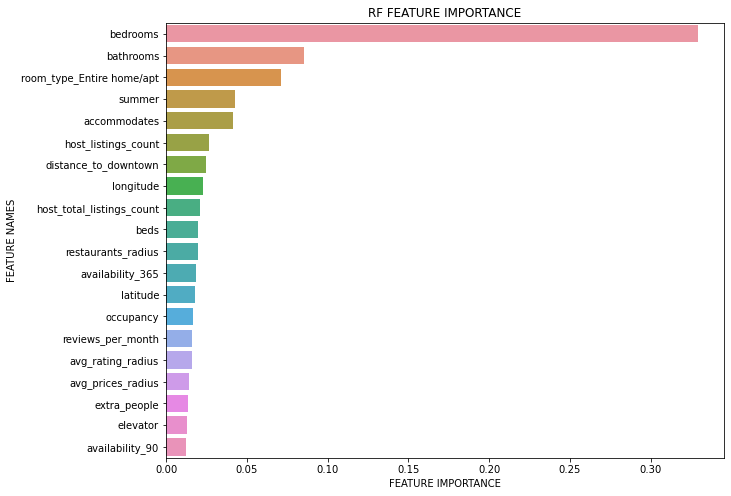

In [108]:
# Let's plot it
_ =plot_feature_importance(rf3.feature_importances_,X_train[old_features+new_features].columns,'RF',20)

### 9.4.4 - RF best features with created features.   
Now let's try to get a subset of features using best features in RF to see if we diminish factors like overfitting.  

In [109]:
best_20_features_nf = get_best_features(rf3.feature_importances_,X_train[old_features+new_features].columns,'RF',20)

In [110]:
rf4 = RandomForestRegressor()
rf4.fit(X_train[best_20_features_nf],y_train)
y_preds = rf4.predict(X_val[best_20_features_nf])
print('Output of Metrics for Random Forest.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(with created features)

R^2:  0.6994424178685859
MSE:  2900.3482268614043
MAE:  34.124234693562975
MAPE:  0.24481756155163126


With these features we made the model worst but not by much. Considering we only used 20 features it's not bad.

In [111]:
best_60_features_nf = get_best_features(rf3.feature_importances_,X_train[old_features+new_features].columns,'RF',60)
rf5 = RandomForestRegressor()
rf5.fit(X_train[best_60_features_nf],y_train)
y_preds = rf5.predict(X_val[best_60_features_nf])
print('Output of Metrics for Random Forest.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Random Forest.
(with created features)

R^2:  0.7069695787906708
MSE:  2827.711936408002
MAE:  33.69713704417405
MAPE:  0.24376247623946878


With 60 features we do best than with all of the features.

## 9.5 - Catboost

### 9.5.1 - Catboost with 20 best features.

In [112]:
cb1 = CatBoostRegressor(verbose=False)
cb1.fit(X_train[old_features],y_train)
best_20_features_cb = get_best_features(cb1.feature_importances_,X_train[old_features].columns,'CB',20)
cb1.fit(X_train[best_20_features_cb],y_train)
y_preds = cb1.predict(X_val[best_20_features_cb])
print('Output of Metrics for CatBoost model with best 20 features.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for CatBoost model with best 20 features.
(without created features)

R^2:  0.6894151083586351
MSE:  2997.1106813339734
MAE:  34.61285131585003
MAPE:  0.23889630814234045


Just with 20 best features, Catboost does very good compared with our previous models.

### 9.5.2 - Catboost with all features not created.

In [113]:
cb2 = CatBoostRegressor(verbose=False)
cb2.fit(X_train[old_features],y_train)
y_preds = cb2.predict(X_val[old_features])
print('Output of Metrics for CatBoost model.')
print('(without created features)\n')
model_output(y_val,y_preds)

Output of Metrics for CatBoost model.
(without created features)

R^2:  0.6916603361212703
MSE:  2975.444475763381
MAE:  34.89380400243449
MAPE:  0.2439488728259376


Very interesting that CatBoost with all of the features (except the ones we created) didn't improve much over the 20  
best features.

### 9.5.3 - Catboost including created features.

In [114]:
cb3 = CatBoostRegressor(verbose=False)
cb3.fit(X_train[old_features + new_features],y_train)
y_preds = cb3.predict(X_val[old_features + new_features])
print('Output of Metrics for Catboost including created features.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Catboost including created features.
(with created features)

R^2:  0.7619959669003651
MSE:  2296.7132304270685
MAE:  30.46840432077185
MAPE:  0.21908607927609053


We see that including the created features we increased the R2 by almost 6%.

### 9.5.4 - Catboost including created features but with best features.

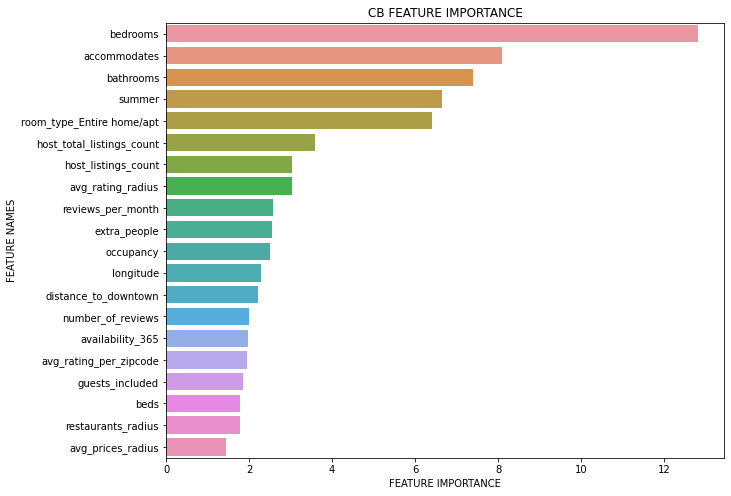

Output of Metrics for Catboost best features.
(with created features)

R^2:  0.7338333872913478
MSE:  2568.4790839237958
MAE:  32.80738840697884
MAPE:  0.23333945054013858


In [115]:
best_20_features_nf_cb = plot_feature_importance(cb3.feature_importances_,X_train[old_features+new_features].columns,'CB',20)
cb4 = CatBoostRegressor(verbose=False)
cb4.fit(X_train[best_20_features_nf_cb],y_train)
y_preds = cb4.predict(X_val[best_20_features_nf_cb])
print('Output of Metrics for Catboost best features.')
print('(with created features)\n')
model_output(y_val,y_preds)

With only 20 features CB gets almost the same result that with all of the features.

In [116]:
best_70_features_nf_cb = get_best_features(cb3.feature_importances_,X_train[old_features+new_features].columns,'CB',70)
cb4 = CatBoostRegressor(verbose=False)
cb4.fit(X_train[best_70_features_nf_cb],y_train)
y_preds = cb4.predict(X_val[best_70_features_nf_cb])
print('Output of Metrics for Catboost best features.')
print('(with created features)\n')
model_output(y_val,y_preds)

Output of Metrics for Catboost best features.
(with created features)

R^2:  0.747022236494266
MSE:  2441.208112655131
MAE:  30.958704568032168
MAPE:  0.2209495577921129


With the best 70 features get's better results

After having played a little with and seen different results with different ammount of features, we'll see in a more
precise way the best ammount of features.

In [117]:
R2 = []
indexes = []
best_r2 = 0
index_best = 0
best_features = []
for index in tqdm_notebook(range(70,86,1)):
    cbc = CatBoostRegressor(verbose=False)
    best_f = get_best_features(cbc.feature_importances_,X_train[old_features+new_features].columns,'CB',index)
    cbc = CatBoostRegressor(verbose=False)
    cbc.fit(X_train[best_f],y_train)
    y_preds = cbc.predict(X_val[best_f])
    r2 = r2_score(y_val,y_preds)
    R2.append(r2)
    indexes.append(index)
    if best_r2 < r2 :
        best_r2 = r2
        index_best = index
        best_features = best_f

C:\Users\Daniel\Anaconda3\envs\P368\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/16 [00:00<?, ?it/s]

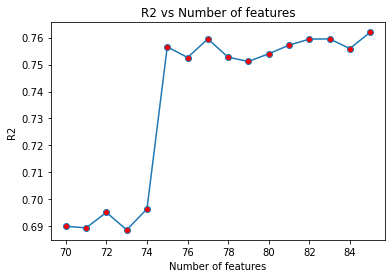

In [118]:
plt.plot(np.array(indexes),np.array(R2),marker='o',markerfacecolor='r')
plt.title('R2 vs Number of features')
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.show()

In [119]:
print(f'The best model had  the best {index_best} features according to Catboost')
print(f'The best R2 score was : {best_r2}')


The best model had  the best 85 features according to Catboost
The best R2 score was : 0.7619959669003651


# 10 - Hyperparameter Tunning

In [120]:
cbc = CatBoostRegressor(verbose=False)

param_dist = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [50,100,300,600,1000]
                 }
rscv = RandomizedSearchCV(cbc , param_dist, scoring='r2', cv =5)
rscv.fit(X_train[best_features],y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.02, 'iterations': 1000, 'depth': 10}
0.8408741884331764


In [121]:
cb_final = CatBoostRegressor(verbose=False,iterations=600, depth=6)
cb_final.fit(X_train[best_features],y_train)
y_preds = cb_final.predict(X_val[best_features])
print('Output of Metrics for Catboost best features .')
print('(with created features and hypertunning)\n')
model_output(y_val,y_preds)

Output of Metrics for Catboost best features .
(with created features and hypertunning)

R^2:  0.7560850174262999
MSE:  2353.753254852992
MAE:  30.55030274278589
MAPE:  0.21886012460702192
